<a href="https://colab.research.google.com/github/mohofar/AI_lessons_mohofar/blob/master/Dicom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reference
###Book:
https://www.amazon.com/Medical-Imaging-Systems-Albert-Macovski/dp/0135726859

### Video:
https://www.youtube.com/watch?v=l9swbAtRRbg

https://www.youtube.com/watch?v=tqGmqRrxajQ

### Sample code:
https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed

https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

https://medium.com/@ashkanpakzad/reading-editing-dicom-metadata-w-python-8204223a59f6

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/


https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing



In [ ]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 88kB/s 


In [ ]:
# # common packages 
import numpy as np 
import os
import copy
import pydicom
import scipy.ndimage
from skimage import measure
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
# set path and load files 
path = '/content/drive/My Drive/AI_lesson/Dicom/Data/LIDC-IDRI-0001/'

In [ ]:
ds = pydicom.filereader.dcmread(path+"1-001.dcm")
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.262721256650280657946440242654
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.26272

In [ ]:
print(ds.PixelSpacing)
print(ds['0028', '0030'].value) # Pixel Spacing 
print(ds['0018', '0050'].value) # Slice Thickness 

[0.703125, 0.703125]
[0.703125, 0.703125]
2.500000


In [ ]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -
                          slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation -  slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Details:
Shape (133, 512, 512)
Min: -2048
Max: 3071
Corner:  -2048


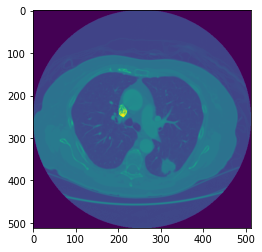

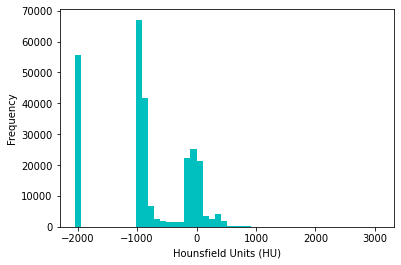

In [ ]:
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
print("Details:")
print("Shape",patient_pixels.shape)
print("Min:",np.amin(patient_pixels))
print("Max:",np.amax(patient_pixels))
#sanity check
plt.imshow(patient_pixels[42])
print("Corner: ",patient_pixels[42][0,0])
plt.show()

plt.hist(patient_pixels[42].flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


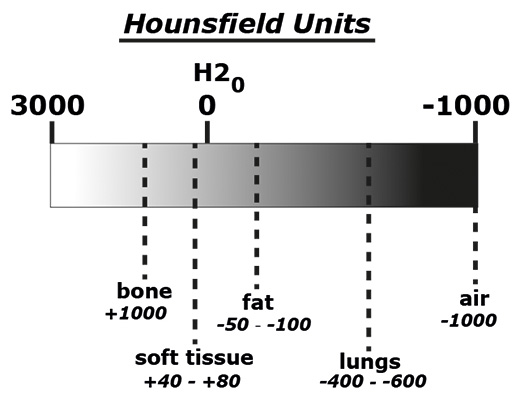



In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0],scan[0].PixelSpacing[1]], dtype=np.float32)
    print("Old spacing\t", spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(patient_pixels, patient_dicom, [1,1,1])
print("Shape before resampling\t", patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Old spacing	 [2.5      0.703125 0.703125]
Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 360, 360)


In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

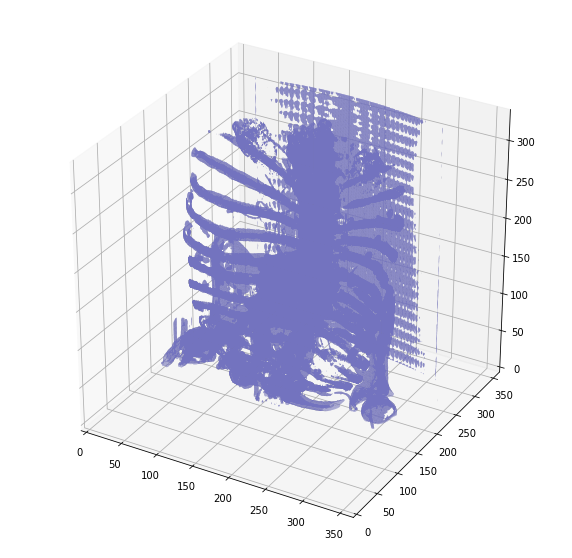

In [ ]:
plot_3d(pix_resampled, 300)

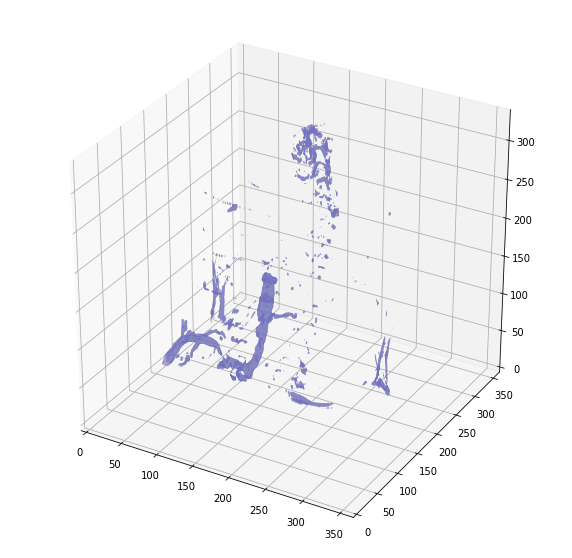

In [ ]:
plot_3d(pix_resampled, 1000)

In [ ]:
'''
The origin represents the position of the first voxel (0,0,0) in the anatomical coordinate system,
e.g. (100mm, 50mm, -25mm)

This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [ ]:
print(voxel_2_world(voxel_coordinates = np.array([1,1,1]),
                    origin = np.array([-100,200,100]),
                    spacing = np.array([1,0.5,0.5])))

[-99.  200.5 100.5]


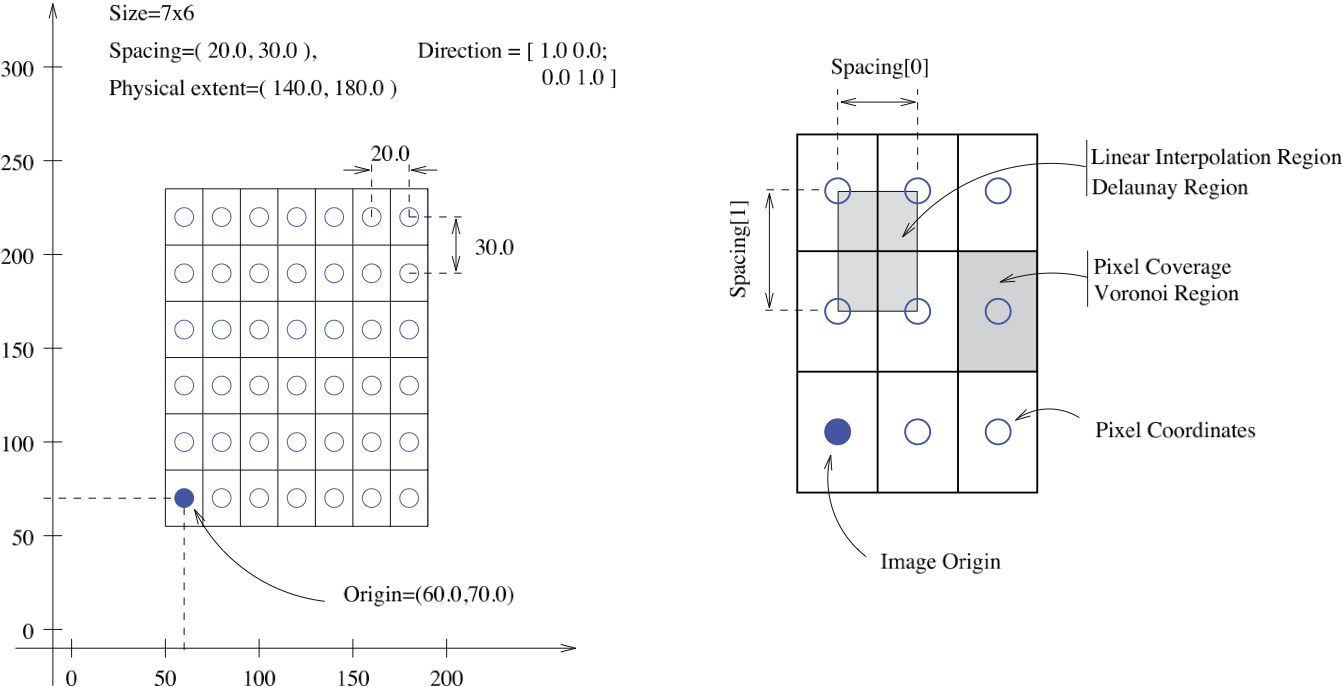


https://simpleitk.org/SPIE2019_COURSE/02_images_and_resampling.html

In [ ]:
path2 = '/content/drive/My Drive/AI_lesson/Dicom/Data/401.000000-T2WTSE-14380/'

Details:
Shape (33, 576, 576)
Min: 0
Max: 2693
Corner:  0


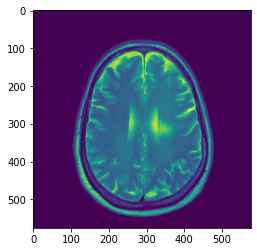

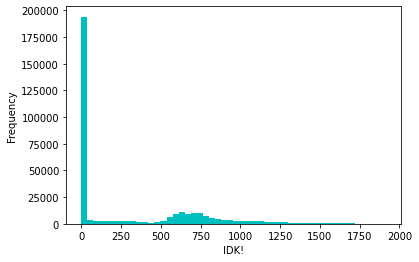

In [ ]:
patient_dicom = load_scan(path2)
patient_pixels = get_pixels_hu(patient_dicom)
print("Details:")
print("Shape",patient_pixels.shape)
print("Min:",np.amin(patient_pixels))
print("Max:",np.amax(patient_pixels))
#sanity check
plt.imshow(patient_pixels[22])
print("Corner: ",patient_pixels[22][0,0])
plt.show()

plt.hist(patient_pixels[22].flatten(), bins=50, color='c')
plt.xlabel("IDK!")
plt.ylabel("Frequency")
plt.show()


In [ ]:
patient_dicom[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7009.2402.138856389110812988208627878895
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '19600411'
(0008, 0013) Instance Creation Time              TM: '150915'
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.14519.5.2.1.7009.

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0]['0018', '0088'].value, scan[0].PixelSpacing[0],scan[0].PixelSpacing[1]], dtype=np.float32)
    print("Old spacing\t", spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
print(patient_dicom[0].PixelSpacing)
print(patient_dicom[0]['0028', '0030'].value) # Pixel Spacing 
print(patient_dicom[0]['0018', '0050'].value) # Slice Thickness 
print(patient_dicom[0]['0018', '0088'].value) # Slice Thickness - ok

[0.39930555224418, 0.39930555224418]
[0.39930555224418, 0.39930555224418]
0.0
6


In [ ]:
pix_resampled, spacing = resample(patient_pixels, patient_dicom, [1,1,1])
print("Shape before resampling\t", patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Old spacing	 [6.         0.39930555 0.39930555]
Shape before resampling	 (33, 576, 576)
Shape after resampling	 (198, 230, 230)
